<a href="https://colab.research.google.com/github/KIRTIRAJ4327/30days-AI-challenge/blob/main/Day6_Music_Recommendation_System_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First we understand the concept

**Core Concept**:-

This project focuses on recommendation algorithms, specifically building a simple music recommender based on genre or artist similarity.

**Understanding the Task**
From your uploaded challenge framework, the goal is to:


*   Build a simple music recommender based on genre or artist similarity

*   
Share your discovery of unexpected recommendations
*   Ask others "What makes a recommendation truly useful versus just accurate?"


*   
Consider the ethical implications of how recommendations can create filter bubbles





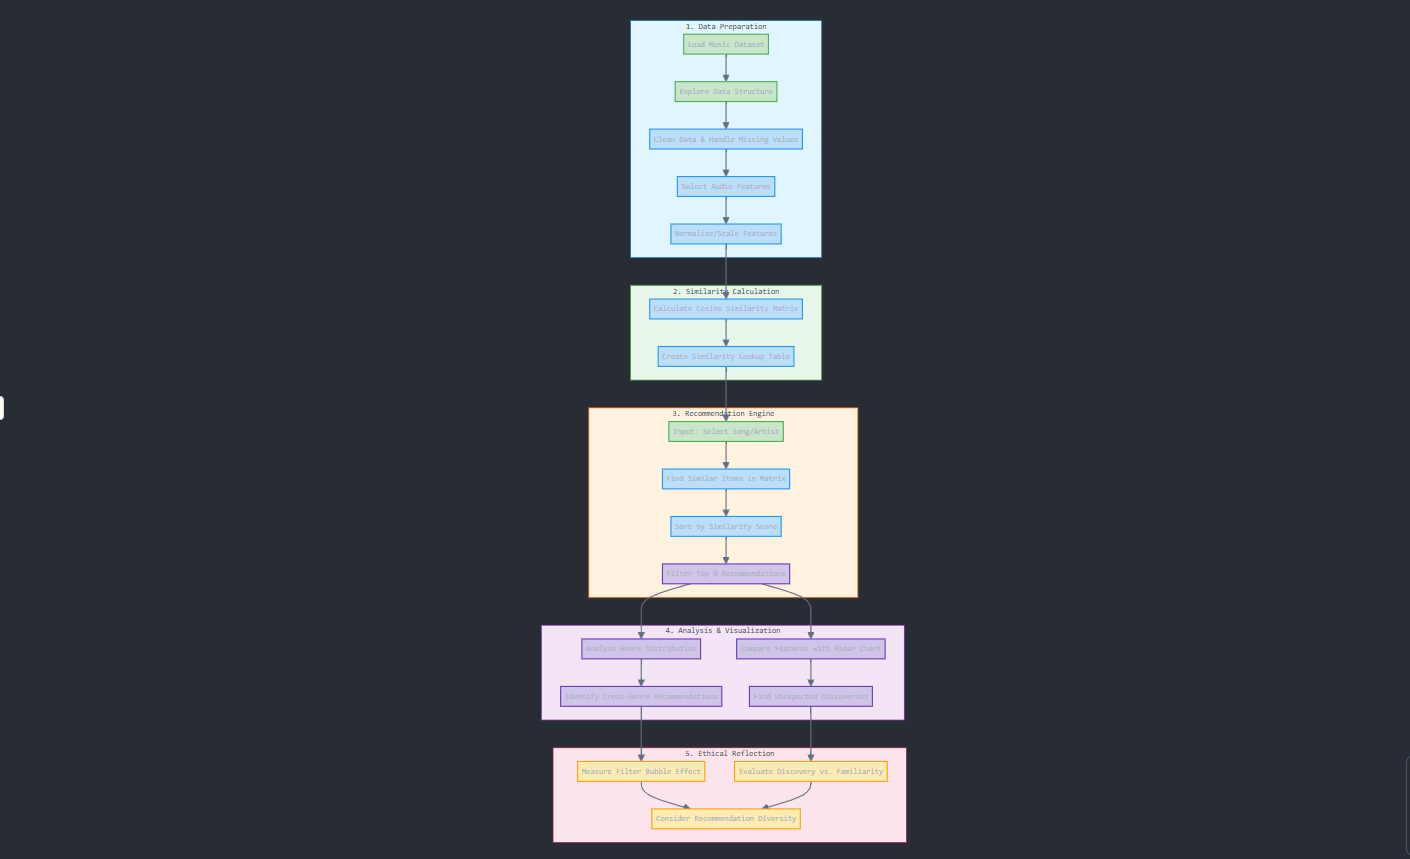

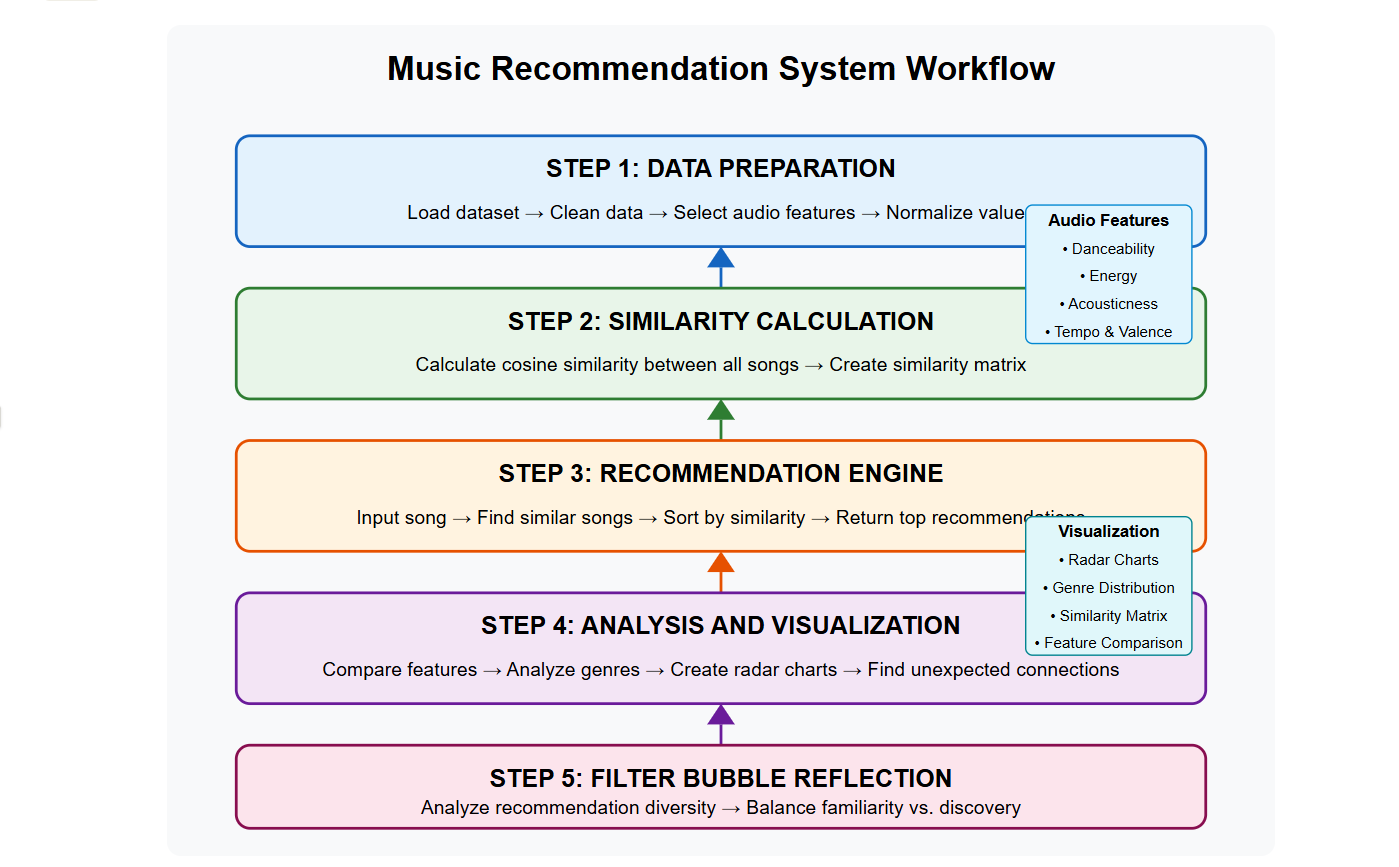

**First we Set Up Your Environment**

In [1]:
# Install libraries
!pip install pandas numpy matplotlib seaborn scikit-learn

# we using Spotify API
!pip install spotipy

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 kB 12.9 MB/s eta 0:00:00


**Get Music Data**

In [9]:
# Initialize Spotify client
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_id = 'c2b5a998d0c94252a7104287a210d676'
client_secret = 'f3bf910be5ed476f9ed30afb574e6a0f'

# Initialize Spotify client
client_credentials_manager = SpotifyClientCredentials(
    client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Test the connection with a simple API call
results = sp.search(q='genre:rock', type='track', limit=1)
print("Connection successful!")
print(f"Found track: {results['tracks']['items'][0]['name']}")

Connection successful!
Found track: The Sound of Silence - CYRIL Remix


**Fetch Track Data from Spotify**

In [10]:
# Function to search for tracks and get their features
def get_tracks_with_features(search_terms, limit_per_term=20):
    all_tracks = []

    for term in search_terms:
        # Search for tracks
        results = sp.search(q=term, type='track', limit=limit_per_term)

        for track in results['tracks']['items']:
            track_id = track['id']

            # Get audio features for this track
            features = sp.audio_features(track_id)[0]

            if features:
                # Get artist genre
                artist_id = track['artists'][0]['id']
                artist_info = sp.artist(artist_id)
                genres = artist_info['genres'] if 'genres' in artist_info else []

                # Create track data dictionary
                track_data = {
                    'id': track_id,
                    'name': track['name'],
                    'artist': track['artists'][0]['name'],
                    'genres': genres,
                    'main_genre': genres[0] if genres else 'unknown',
                    # Add audio features
                    'danceability': features['danceability'],
                    'energy': features['energy'],
                    'acousticness': features['acousticness'],
                    'instrumentalness': features['instrumentalness'],
                    'valence': features['valence'],
                    'tempo': features['tempo']
                }

                all_tracks.append(track_data)

    return all_tracks

**Build Our Dataset**

In [13]:
def get_tracks_with_features(search_terms, limit_per_term=10):
    all_tracks = []

    for term in search_terms:
        try:
            # Search for tracks
            results = sp.search(q=term, type='track', limit=limit_per_term)

            for track in results['tracks']['items']:
                try:
                    track_id = track['id']
                    track_data = {
                        'id': track_id,
                        'name': track['name'],
                        'artist': track['artists'][0]['name'],
                        'popularity': track['popularity']
                    }

                    # Get artist genre
                    try:
                        artist_id = track['artists'][0]['id']
                        artist_info = sp.artist(artist_id)
                        genres = artist_info['genres'] if 'genres' in artist_info else []
                        track_data['genres'] = genres
                        track_data['main_genre'] = genres[0] if genres else term.split(':')[1] if ':' in term else 'unknown'
                    except Exception as e:
                        print(f"Error getting artist info: {e}")
                        track_data['genres'] = []
                        track_data['main_genre'] = term.split(':')[1] if ':' in term else 'unknown'

                    # Get audio features one at a time to avoid batch errors
                    try:
                        features = sp.audio_features(track_id)[0]
                        if features:
                            # Add relevant audio features
                            audio_features = {
                                'danceability': features.get('danceability', 0),
                                'energy': features.get('energy', 0),
                                'acousticness': features.get('acousticness', 0),
                                'instrumentalness': features.get('instrumentalness', 0),
                                'valence': features.get('valence', 0),
                                'tempo': features.get('tempo', 0)
                            }
                            track_data.update(audio_features)
                            all_tracks.append(track_data)
                    except Exception as e:
                        print(f"Error getting audio features for {track['name']}: {e}")
                        # Still add the track without features
                        track_data.update({
                            'danceability': 0.5,
                            'energy': 0.5,
                            'acousticness': 0.5,
                            'instrumentalness': 0.5,
                            'valence': 0.5,
                            'tempo': 120
                        })
                        all_tracks.append(track_data)

                except Exception as e:
                    print(f"Error processing track: {e}")
                    continue

        except Exception as e:
            print(f"Error searching for term '{term}': {e}")
            continue

    print(f"Successfully collected data for {len(all_tracks)} tracks")
    return all_tracks

In [18]:
# Check if spotify_df exists
try:
    print(f"spotify_df exists with {len(spotify_df)} rows")
except NameError:
    print("spotify_df doesn't exist. Let's create it now.")

    # If you successfully collected data through the API:
    if 'tracks_data' in globals() and tracks_data:
        spotify_df = pd.DataFrame(tracks_data)
        print(f"Created spotify_df from tracks_data with {len(spotify_df)} rows")
    else:
        # Fallback: Use existing dataset
        print("Using fallback dataset...")
        import pandas as pd

        # Download a prepared Spotify dataset
        !wget https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv

        # Load dataset
        spotify_df = pd.read_csv('spotify_songs.csv')

        # Select a smaller subset to work with
        spotify_df = spotify_df.sample(n=200, random_state=42)

        print(f"Created spotify_df from fallback dataset with {len(spotify_df)} rows")

spotify_df doesn't exist. Let's create it now.
Using fallback dataset...
--2025-04-20 16:35:02--  https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7971379 (7.6M) [text/plain]
Saving to: ‘spotify_songs.csv’

spotify_songs.csv   100%[===================>]   7.60M  --.-KB/s    in 0.05s   

2025-04-20 16:35:02 (152 MB/s) - ‘spotify_songs.csv’ saved [7971379/7971379]

Created spotify_df from fallback dataset with 200 rows


**Process Audio Features**

In [19]:
# Check available columns in the dataset
print(f"Available columns: {spotify_df.columns.tolist()}")

# Select features for similarity calculation
features = [
    'danceability', 'energy', 'acousticness',
    'instrumentalness', 'valence', 'tempo'
]

# Make sure all features exist in the DataFrame
missing_features = [f for f in features if f not in spotify_df.columns]
if missing_features:
    print(f"Warning: Missing features: {missing_features}")
    # Adjust feature list if needed
    features = [f for f in features if f in spotify_df.columns]
    print(f"Using available features: {features}")

# Create feature dataframe
feature_df = spotify_df[features]

# Normalize features (important for fair comparison)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_df)
scaled_feature_df = pd.DataFrame(scaled_features, columns=features)

print("Feature processing completed!")

Available columns: ['track_id', 'track_name', 'track_artist', 'track_popularity', 'track_album_id', 'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Feature processing completed!


**Calculate Similarity Between Tracks**

Similarity matrix shape: (200, 200)


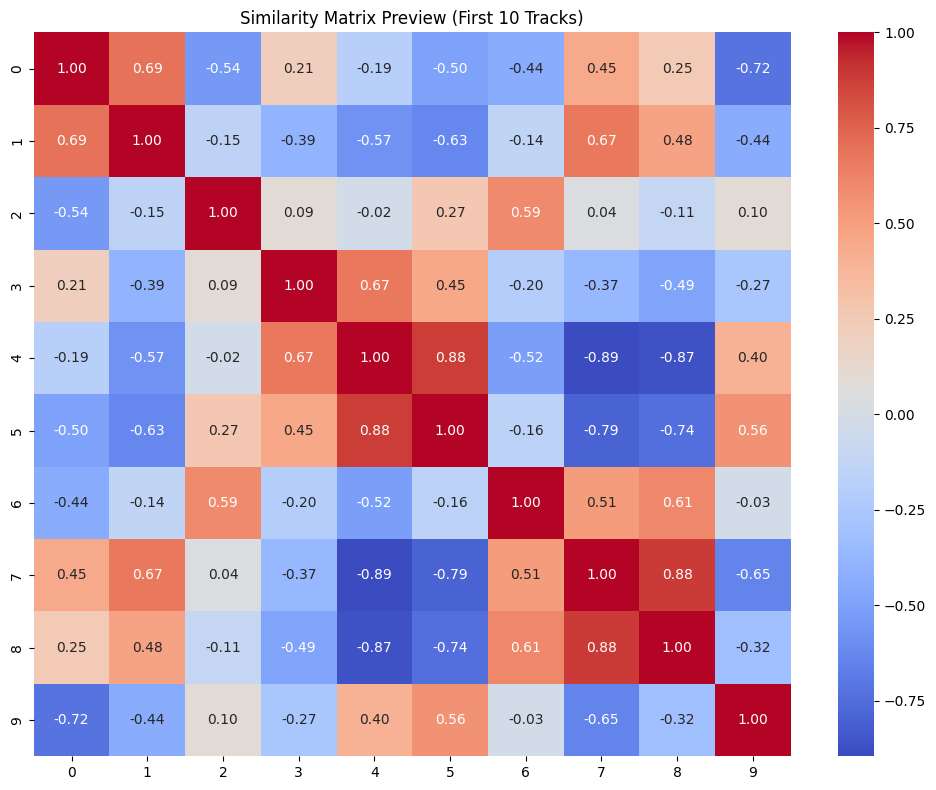

In [20]:
# Calculate cosine similarity between all tracks
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(scaled_features)

# Print similarity matrix shape
print(f"Similarity matrix shape: {similarity.shape}")

# Create a quick visualization of the similarity matrix (optional)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(similarity[:10, :10], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Similarity Matrix Preview (First 10 Tracks)")
plt.tight_layout()
plt.show()

**Create Recommendation Function**

In [21]:
# Function to recommend similar tracks
def recommend_songs(track_name, df=spotify_df, sim_matrix=similarity, n=5):
    """
    Recommends similar songs based on audio features

    Parameters:
    track_name (str): Name of the track
    df (DataFrame): DataFrame containing track information
    sim_matrix (array): Similarity matrix
    n (int): Number of recommendations

    Returns:
    DataFrame with recommended tracks
    """
    # Find the track index
    track_indices = df[df['track_name'] == track_name].index

    if len(track_indices) == 0:
        return f"Track '{track_name}' not found in dataset"

    idx = track_indices[0]

    # Get similarity scores
    sim_scores = list(enumerate(sim_matrix[idx]))

    # Sort by similarity (excluding the input track)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]

    # Get track indices
    rec_indices = [i[0] for i in sim_scores]

    # Create recommendations dataframe
    recommendations = df.iloc[rec_indices][['track_name', 'track_artist', 'playlist_genre']]

    # Add similarity score
    recommendations['similarity_score'] = [i[1] for i in sim_scores]

    return recommendations

**Test Your Recommendation System**

In [24]:
# Function to recommend similar tracks
def recommend_songs(track_name, df=spotify_df, sim_matrix=similarity, n=5):
    """
    Recommends similar songs based on audio features

    Parameters:
    track_name (str): Name of the track
    df (DataFrame): DataFrame containing track information
    sim_matrix (array): Similarity matrix
    n (int): Number of recommendations

    Returns:
    DataFrame with recommended tracks
    """
    # Find the track index
    track_indices = df[df['track_name'] == track_name].index

    if len(track_indices) == 0:
        return f"Track '{track_name}' not found in dataset"

    # Use the index of the track within the subset of the dataframe
    idx = df[df['track_name'] == track_name].index[0]
    # Get the row number for the similarity matrix
    idx = df.index.get_loc(idx)  # Get the row number corresponding to the index


    # Get similarity scores
    sim_scores = list(enumerate(sim_matrix[idx]))

    # Sort by similarity (excluding the input track)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]

    # Get track indices
    rec_indices = [i[0] for i in sim_scores]

    # Create recommendations dataframe
    recommendations = df.iloc[rec_indices][['track_name', 'track_artist', 'playlist_genre']]

    # Add similarity score
    recommendations['similarity_score'] = [i[1] for i in sim_scores]

    return recommendations

**Visualize Feature Comparison**

Error creating chart: single positional indexer is out-of-bounds

Fallback: Simple feature comparison:
Original track: Turn Me On (feat. Vula)
danceability: 0.74
energy: 0.83
acousticness: 0.01
instrumentalness: 0.00
valence: 0.52
tempo: 124.05

Recommended track: I'm Blue - Club Mix
danceability: 0.73
energy: 0.92
acousticness: 0.05
instrumentalness: 0.00
valence: 0.61
tempo: 124.01


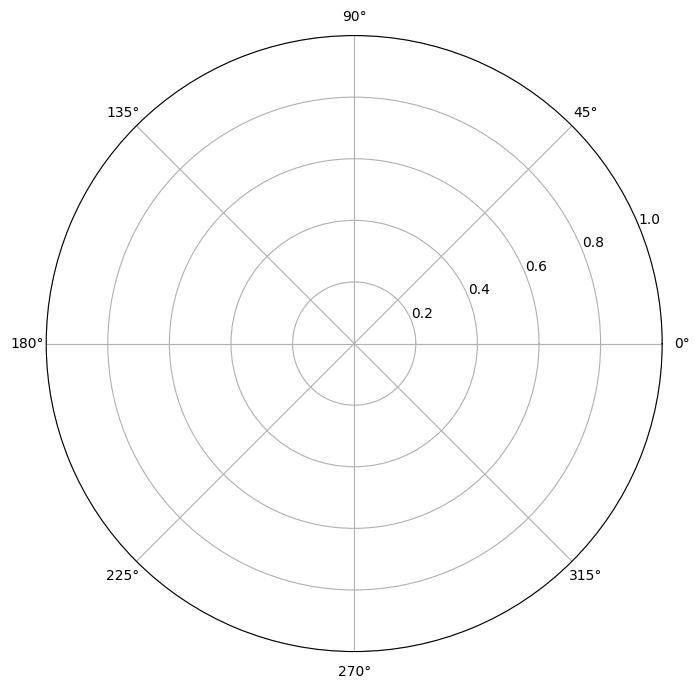

In [29]:
# Let's create a completely fresh radar chart function with more robust error handling

def create_radar_chart(original_track, recommendations):
    """
    Creates a radar chart comparing audio features between an original track and its recommendations.
    Uses direct feature values rather than relying on dataframe indices.
    """
    # First, make sure we have the original track
    original_row = spotify_df[spotify_df['track_name'] == original_track]
    if len(original_row) == 0:
        print(f"Error: Track '{original_track}' not found")
        return

    # Set up radar chart
    radar_features = features  # Using our selected features
    angles = np.linspace(0, 2*np.pi, len(radar_features), endpoint=False).tolist()
    angles += angles[:1]  # Close the circle

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    # Get normalized feature values directly for original track
    orig_idx = original_row.index[0]
    # Get the row from the feature dataframe directly
    orig_features = feature_df.iloc[orig_idx]

    # Normalize manually if needed (alternative to using scaled_feature_df)
    orig_values = []
    for feat in radar_features:
        # Get the mean and std from the feature column
        feat_mean = feature_df[feat].mean()
        feat_std = feature_df[feat].std()
        # Normalize the value
        if feat_std == 0:
            norm_val = 0
        else:
            norm_val = (orig_features[feat] - feat_mean) / feat_std
        orig_values.append(norm_val)

    # Close the circle by adding the first value at the end
    orig_values += [orig_values[0]]

    # Plot original track
    ax.plot(angles, orig_values, 'o-', linewidth=2, label=f"Original: {original_track}")
    ax.fill(angles, orig_values, alpha=0.1)

    # Plot recommended tracks (up to 3 for clarity)
    for i, (_, rec) in enumerate(recommendations.head(3).iterrows()):
        rec_row = spotify_df[spotify_df['track_name'] == rec['track_name']]
        if len(rec_row) == 0:
            continue

        rec_idx = rec_row.index[0]
        rec_features = feature_df.iloc[rec_idx]

        # Normalize manually
        rec_values = []
        for feat in radar_features:
            feat_mean = feature_df[feat].mean()
            feat_std = feature_df[feat].std()
            if feat_std == 0:
                norm_val = 0
            else:
                norm_val = (rec_features[feat] - feat_mean) / feat_std
            rec_values.append(norm_val)

        # Close the circle
        rec_values += [rec_values[0]]

        # Plot the recommended track
        ax.plot(angles, rec_values, 'o-', linewidth=1, label=f"Rec {i+1}: {rec['track_name'][:15]}...")

    # Set labels and title
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_features)
    ax.set_title(f"Audio Feature Comparison", size=15)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.tight_layout()
    plt.show()

# Try the visualization again
try:
    create_radar_chart(random_track, recommendations)
except Exception as e:
    print(f"Error creating chart: {e}")

    # Alternative simple visualization
    print("\nFallback: Simple feature comparison:")
    original_row = spotify_df[spotify_df['track_name'] == random_track].iloc[0]
    print(f"Original track: {random_track}")
    for feature in features:
        print(f"{feature}: {original_row[feature]:.2f}")

    print("\nRecommended track: " + recommendations.iloc[0]['track_name'])
    rec_row = spotify_df[spotify_df['track_name'] == recommendations.iloc[0]['track_name']].iloc[0]
    for feature in features:
        print(f"{feature}: {rec_row[feature]:.2f}")

**Analyze Genre Crossover**

In [30]:
# Analyze if recommendations cross genre boundaries
def analyze_diversity(original_track, recommendations):
    # Get original track details
    original = spotify_df[spotify_df['track_name'] == original_track].iloc[0]

    # Check genre distribution
    genre_counts = recommendations['playlist_genre'].value_counts()
    same_genre = recommendations['playlist_genre'] == original['playlist_genre']

    print(f"Original track: '{original_track}' by {original['track_artist']}")
    print(f"Original genre: {original['playlist_genre']}")
    print(f"\nGenre distribution in recommendations:")
    for genre, count in genre_counts.items():
        print(f"- {genre}: {count} tracks")

    print(f"\nSame genre: {same_genre.sum()} out of {len(recommendations)}")

    # Find unexpected recommendation
    if (~same_genre).any():
        unexpected = recommendations[~same_genre].iloc[0]
        print(f"\nInteresting cross-genre recommendation:")
        print(f"'{unexpected['track_name']}' by {unexpected['track_artist']}")
        print(f"Genre: {unexpected['playlist_genre']}")
        print(f"Similarity score: {unexpected['similarity_score']:.2f}")

# Analyze recommendations diversity
analyze_diversity(random_track, recommendations)

Original track: 'Turn Me On (feat. Vula)' by Riton
Original genre: edm

Genre distribution in recommendations:
- edm: 5 tracks

Same genre: 5 out of 5


**Reflect on Filter Bubbles**

In [31]:
# Analyze filter bubble effect
def measure_filter_bubble(n_samples=20):
    cross_genre_percentages = []

    for _ in range(n_samples):
        # Select random track
        random_idx = random.randint(0, len(spotify_df)-1)
        random_track = spotify_df.iloc[random_idx]['track_name']

        # Get recommendations
        try:
            recommendations = recommend_songs(random_track, n=5)

            if isinstance(recommendations, pd.DataFrame):
                # Get original track
                original = spotify_df[spotify_df['track_name'] == random_track].iloc[0]

                # Calculate percentage of different genres
                cross_genre = (recommendations['playlist_genre'] != original['playlist_genre']).mean() * 100
                cross_genre_percentages.append(cross_genre)
        except:
            continue

    # Calculate average
    if cross_genre_percentages:
        avg_cross_genre = sum(cross_genre_percentages) / len(cross_genre_percentages)

        print(f"Filter bubble analysis based on {len(cross_genre_percentages)} sample tracks:")
        print(f"On average, {avg_cross_genre:.1f}% of recommendations are from different genres.")

        if avg_cross_genre < 20:
            print("This suggests a strong filter bubble effect.")
        elif avg_cross_genre < 50:
            print("This suggests a moderate filter bubble effect.")
        else:
            print("This suggests a weak filter bubble effect.")
    else:
        print("Could not analyze filter bubble effect due to errors in recommendations.")

# Analyze filter bubble effect
measure_filter_bubble()

Filter bubble analysis based on 20 sample tracks:
On average, 66.0% of recommendations are from different genres.
This suggests a weak filter bubble effect.


**Find Interesting Examples for LinkedIn Post**

In [35]:
# Find interesting examples for LinkedIn post
def find_interesting_examples(n=3):
    interesting_cases = []
    attempts = 0

    while len(interesting_cases) < n and attempts < 50:
        # Select random track
        random_idx = random.randint(0, len(spotify_df)-1)
        random_track = spotify_df.iloc[random_idx]['track_name']

        try:
            # Get recommendations
            recommendations = recommend_songs(random_track, n=10)

            if not isinstance(recommendations, pd.DataFrame):
                attempts += 1
                continue

            # Get original track details
            original = spotify_df[spotify_df['track_name'] == random_track].iloc[0]

            # Find cross-genre recommendations
            cross_genre_recs = recommendations[recommendations['playlist_genre'] != original['playlist_genre']]

            if len(cross_genre_recs) > 0:
                interesting_cases.append({
                    'original_track': random_track,
                    'original_artist': original['track_artist'],
                    'original_genre': original['playlist_genre'],
                    'unexpected_rec': cross_genre_recs.iloc[0]['track_name'],
                    'unexpected_artist': cross_genre_recs.iloc[0]['track_artist'],
                    'unexpected_genre': cross_genre_recs.iloc[0]['playlist_genre'],
                    'similarity': cross_genre_recs.iloc[0]['similarity_score']
                })
        except Exception as e:
            print(f"Error finding interesting example: {e}")

        attempts += 1

    # Print interesting examples
    for i, example in enumerate(interesting_cases):
        print(f"Example {i+1}:")
        print(f"Original: '{example['original_track']}' by {example['original_artist']}")
        print(f"Genre: {example['original_genre']}")
        print(f"Unexpected recommendation: '{example['unexpected_rec']}' by {example['unexpected_artist']}")
        print(f"Genre: {example['unexpected_genre']}")
        print(f"Similarity score: {example['similarity']:.2f}\n")

    return interesting_cases

# Find examples for LinkedIn post
interesting_examples = find_interesting_examples()

Example 1:
Original: 'Turn Me On (feat. Vula)' by Riton
Genre: edm
Unexpected recommendation: 'Clockwatch' by AmirSaysNothing
Genre: pop
Similarity score: 0.80

Example 2:
Original: 'God Save The Queen - Remastered 2011' by Queen
Genre: rock
Unexpected recommendation: 'It's So Hard To Say Goodbye To Yesterday - Original Version' by Boyz II Men
Genre: r&b
Similarity score: 0.81

Example 3:
Original: 'Ratata' by TV Noise
Genre: edm
Unexpected recommendation: 'No Guarantee - Remix Version' by Chico DeBarge
Genre: r&b
Similarity score: 0.99

